# Mlp Higgs
Example of a Multi Layer Perceptron
For a LEP search for invisible Higgs boson, a neural network
was used to separate the signal from the background passing
some selection cuts. Here is a simplified version of this network,
taking into account only WW events.




**Author:** Christophe Delaere  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 02:14 AM.</small></i>

 Arguments are defined. 

In [1]:
Int_t ntrain=100;

In [2]:
const char *fname = "mlpHiggs.root";
TFile *input = 0;
if (!gSystem->AccessPathName(fname)) {
   input = TFile::Open(fname);
} else if (!gSystem->AccessPathName(Form("%s/mlp/%s", TROOT::GetTutorialDir().Data(), fname))) {
   input = TFile::Open(Form("%s/mlp/%s", TROOT::GetTutorialDir().Data(), fname));
} else {
   printf("accessing %s file from http://root.cern.ch/files\n",fname);
   input = TFile::Open(Form("http://root.cern.ch/files/%s",fname));
}
if (!input) return;

TTree *sig_filtered = (TTree *) input->Get("sig_filtered");
TTree *bg_filtered = (TTree *) input->Get("bg_filtered");
TTree *simu = new TTree("MonteCarlo", "Filtered Monte Carlo Events");
Float_t ptsumf, qelep, nch, msumf, minvis, acopl, acolin;
Int_t type;
sig_filtered->SetBranchAddress("ptsumf", &ptsumf);
sig_filtered->SetBranchAddress("qelep",  &qelep);
sig_filtered->SetBranchAddress("nch",    &nch);
sig_filtered->SetBranchAddress("msumf",  &msumf);
sig_filtered->SetBranchAddress("minvis", &minvis);
sig_filtered->SetBranchAddress("acopl",  &acopl);
sig_filtered->SetBranchAddress("acolin", &acolin);
bg_filtered->SetBranchAddress("ptsumf", &ptsumf);
bg_filtered->SetBranchAddress("qelep",  &qelep);
bg_filtered->SetBranchAddress("nch",    &nch);
bg_filtered->SetBranchAddress("msumf",  &msumf);
bg_filtered->SetBranchAddress("minvis", &minvis);
bg_filtered->SetBranchAddress("acopl",  &acopl);
bg_filtered->SetBranchAddress("acolin", &acolin);
simu->Branch("ptsumf", &ptsumf, "ptsumf/F");
simu->Branch("qelep",  &qelep,  "qelep/F");
simu->Branch("nch",    &nch,    "nch/F");
simu->Branch("msumf",  &msumf,  "msumf/F");
simu->Branch("minvis", &minvis, "minvis/F");
simu->Branch("acopl",  &acopl,  "acopl/F");
simu->Branch("acolin", &acolin, "acolin/F");
simu->Branch("type",   &type,   "type/I");
type = 1;
Int_t i;
for (i = 0; i < sig_filtered->GetEntries(); i++) {
   sig_filtered->GetEntry(i);
   simu->Fill();
}
type = 0;
for (i = 0; i < bg_filtered->GetEntries(); i++) {
   bg_filtered->GetEntry(i);
   simu->Fill();
}

Build and train the nn ptsumf is used as a weight since we are primarily
 interested  by high pt events.
 The datasets used here are the same as the default ones.

In [3]:
TMultiLayerPerceptron *mlp =
   new TMultiLayerPerceptron("@msumf,@ptsumf,@acolin:5:3:type",
                             "ptsumf",simu,"Entry$%2","(Entry$+1)%2");
mlp->Train(ntrain, "text,graph,update=10");
mlp->Export("test","python");

Training the Neural Network
Epoch: 0 learn=0.126634 test=0.125692


Info in <TMultiLayerPerceptron::Train>: Using 979 train and 979 test entries.


Epoch: 10 learn=0.0969641 test=0.0915638
Epoch: 20 learn=0.0930031 test=0.0888199
Epoch: 30 learn=0.0917136 test=0.088847
Epoch: 40 learn=0.0911658 test=0.0883143
Epoch: 50 learn=0.0907057 test=0.0875496
Epoch: 60 learn=0.0903087 test=0.0876758
Epoch: 70 learn=0.0900667 test=0.0869323
Epoch: 80 learn=0.0898808 test=0.0865657
Epoch: 90 learn=0.0894948 test=0.0864274
Epoch: 99 learn=0.0893715 test=0.0860583
Training done.
test.py created.


Use tmlpanalyzer to see what it looks for

In [4]:
TCanvas* mlpa_canvas = new TCanvas("mlpa_canvas","Network analysis");
mlpa_canvas->Divide(2,2);
TMLPAnalyzer ana(mlp);

Initialisation

In [5]:
ana.GatherInformations();

Output to the console

In [6]:
ana.CheckNetwork();
mlpa_canvas->cd(1);

Network with structure: @msumf,@ptsumf,@acolin:5:3:type
inputs with low values in the differences plot may not be needed
@msumf -> 0.018108 +/- 0.0120525
@ptsumf -> 0.0298452 +/- 0.0375788
@acolin -> 0.0275104 +/- 0.0305884


Shows how each variable influences the network

In [7]:
ana.DrawDInputs();
mlpa_canvas->cd(2);

Shows the network structure

In [8]:
mlp->Draw();
mlpa_canvas->cd(3);

Draws the resulting network

In [9]:
ana.DrawNetwork(0,"type==1","type==0");
mlpa_canvas->cd(4);

Use the nn to plot the results for each sample
 This will give approx. the same result as DrawNetwork.
 All entries are used, while DrawNetwork focuses on
 the test sample. Also the xaxis range is manually set.

In [10]:
TH1F *bg = new TH1F("bgh", "NN output", 50, -.5, 1.5);
TH1F *sig = new TH1F("sigh", "NN output", 50, -.5, 1.5);
bg->SetDirectory(0);
sig->SetDirectory(0);
Double_t params[3];
for (i = 0; i < bg_filtered->GetEntries(); i++) {
   bg_filtered->GetEntry(i);
   params[0] = msumf;
   params[1] = ptsumf;
   params[2] = acolin;
   bg->Fill(mlp->Evaluate(0, params));
}
for (i = 0; i < sig_filtered->GetEntries(); i++) {
   sig_filtered->GetEntry(i);
   params[0] = msumf;
   params[1] = ptsumf;
   params[2] = acolin;
   sig->Fill(mlp->Evaluate(0,params));
}
bg->SetLineColor(kBlue);
bg->SetFillStyle(3008);   bg->SetFillColor(kBlue);
sig->SetLineColor(kRed);
sig->SetFillStyle(3003); sig->SetFillColor(kRed);
bg->SetStats(0);
sig->SetStats(0);
bg->Draw();
sig->Draw("same");
TLegend *legend = new TLegend(.75, .80, .95, .95);
legend->AddEntry(bg, "Background (WW)");
legend->AddEntry(sig, "Signal (Higgs)");
legend->Draw();
mlpa_canvas->cd(0);
delete input;

Draw all canvases 

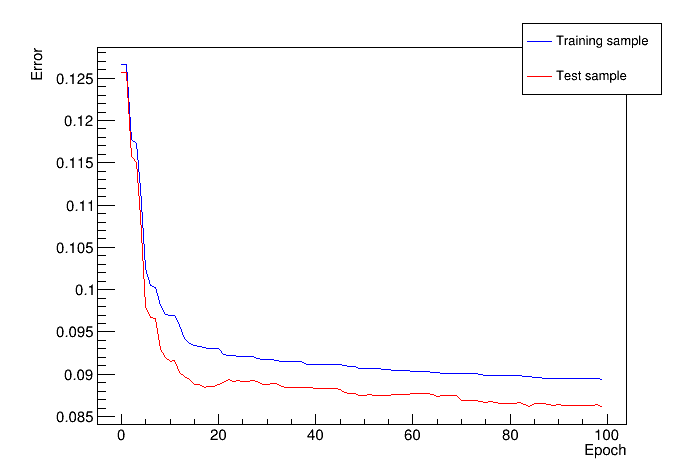

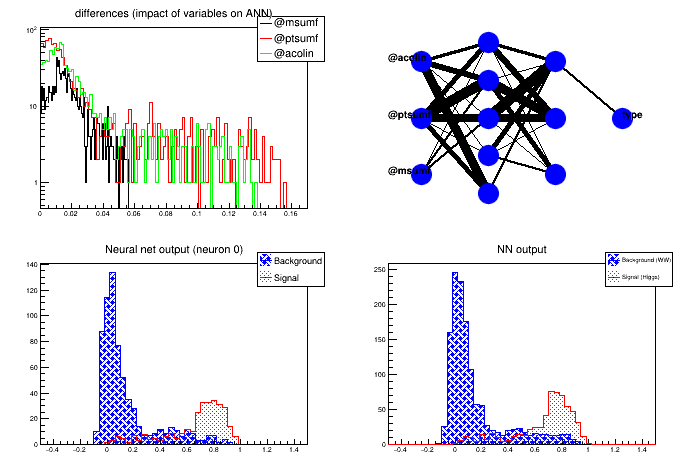

In [11]:
gROOT->GetListOfCanvases()->Draw()